## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

0.  <a href="#item0">IMPORTING & INSTALLING THE REQUIRED LIBRARIES</a>

1.  <a href="#item1">DOWNLOAD & EXPLORE THE DATASET</a>

2.  <a href="#item2">EXPLORE THE NEIGHBOURHOODS IN TORONTO CITY</a>

3.  <a href="#item3">ANALYZE EACH NEIGHBOURHOOD</a>

4.  <a href="#item4">CLUSTER NEIGHBOURHOODS</a>

5.  <a href="#item5">EXAMINE CLUSTERS</a>  
    </font>
    </div>


<a id='item0'></a>

# 0. IMPORTING & INSTALLING THE REQUIRED LIBRARIES

In [3]:
import pandas as pd
import numpy as np
import requests
import json
from pandas import json_normalize

from sklearn.cluster import KMeans
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors


## We need lxml, html5 and beautifulsoup4 for web scraping

In [4]:
!pip install lxml html5lib beautifulsoup4

You should consider upgrading via the 'f:\anaconda\python.exe -m pip install --upgrade pip' command.


<a id='item1'></a>

# 1. DOWNLOAD & EXPLORE THE DATASET

### Scrape the wikipedia webpage using pandas
###            We can use the read_html(url) function to get webpage contents

In [5]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
list_web=pd.read_html(url)

## Get the dataframe required dataframe from a list of dataframes
#### read_html(url) returns a list of all the tables from the webpage. We require the first table from the webpage. So we will be using list_web[0]  for our dataframe


In [6]:
df_web=list_web[0]
df_web.head(3)

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods


## Remove all the rows containing 'Not assigned' in its 'Borough' column

In [7]:
df_web=df_web[df_web['Borough']!='Not assigned']
df_web.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


## Since we deleted a few rows, we will be needing to reset the index

In [8]:
df_web.reset_index(inplace=True)
df_web.drop('index',axis=1,inplace=True)

F:\anaconda\lib\site-packages\pandas\core\frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## A final peek of our dataframe

In [9]:
df_web

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


## No of rows and columns in our dataframe

In [10]:
df_web.shape

(103, 3)

### Python's geocoder package for geographical coordinates can be very unreliable. So , I used the data provided through the csv

In [11]:
url2='https://cocl.us/Geospatial_data'
df_cord=pd.read_csv(url2)
df_cord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### For our required dataframe we will need to merge both dataframes( df_web & df_cord) with respect to the column ('Postal Code') as the key .

In [12]:
df_final=pd.merge(df_web,df_cord,on='Postal Code')

### This is our result that we got after the merge.

In [13]:
df_final

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


### Now we need to explore and cluster the neighbourhoods in Toronto. So we filter out all the Boroughs containing 'Toronto' into a separate dataframe

In [14]:
temp=['Toronto' in each for each in df_final['Borough']]
df_toronto=df_final[temp]
df_toronto.head()
df_toronto.reset_index(drop=True,inplace=True)
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [15]:
a=df_toronto.loc[0,'Neighbourhood']
a=a.split(',')[0]
a
N_LATITUDE=df_toronto.loc[0,'Latitude']
N_LONGITUDE=df_toronto.loc[0,'Longitude']
type(N_LATITUDE),N_LATITUDE,N_LONGITUDE

(numpy.float64, 43.6542599, -79.3606359)

<a id='item2'></a>

# 2. EXPLORE THE NEIGHBOURHOODS IN TORONTO CITY

### Setup to use the foursquare API

In [16]:
CLIENT_ID = 'S01X3E5GTFLE31LD3QX2LNR2TSY0XIIE5DYXOUOR1OMEHXBH' # your Foursquare ID
CLIENT_SECRET = 'B2QL1LH3NAM2LG0SQTXDJSY1EUOG4REZRT2TZUKA1ZNGZX1T' # your Foursquare Secret
# CLIENT_ID='ZHN1PY5PXKH2V2NTF0VTQSXFFWO4E03EMBFVCZG0VLSGSUIO'
# CLIENT_SECRET='Q15C4UOQLL5JV1FEW3E1OV0ODDMD24IGB1AOM35B4OZBSSTV'

VERSION = '20211010' # Foursquare API version
RADIUS=500
LIMIT=100

url3='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'
url4='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    N_LATITUDE,
    N_LONGITUDE,
    RADIUS,
    LIMIT
)

### a single request to check if everything's working fine & also to check what kind of response we get from the api and what kind of variables are present in the response json file

In [17]:
b=requests.get(url4).json()
b=b['response']['groups'][0]['items']
b=json_normalize(b)
req_columns=['venue.name','venue.categories','venue.location.lat','venue.location.lng']
b=b[req_columns]
b

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Roselle Desserts,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",43.653447,-79.362017
1,Tandem Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.653559,-79.361809
2,Cooper Koo Family YMCA,"[{'id': '52e81612bcbc57f1066b7a37', 'name': 'D...",43.653249,-79.358008
3,Morning Glory Cafe,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",43.653947,-79.361149
4,Body Blitz Spa East,"[{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...",43.654735,-79.359874
5,Impact Kitchen,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.656369,-79.356980
6,The Extension Room,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",43.653313,-79.359725
7,Corktown Common,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",43.655618,-79.356211
8,The Distillery Historic District,"[{'id': '4deefb944765f83613cdba6e', 'name': 'H...",43.650244,-79.359323
9,SOMA chocolatemaker,"[{'id': '52f2ab2ebcbc57f1066b8b31', 'name': 'C...",43.650622,-79.358127


### some random checking before the actual request is made

In [18]:
# c=json_normalize(b['response']['groups'][0]['items'])
# c

### some random checking before the actual request is made

In [19]:
temp=b.loc[1,'venue.categories']
temp[0]['name']

'Coffee Shop'

### Setup to use the foursquare API

In [20]:
# CLIENT_ID = 'S01X3E5GTFLE31LD3QX2LNR2TSY0XIIE5DYXOUOR1OMEHXBH' # your Foursquare ID
# CLIENT_SECRET = 'B2QL1LH3NAM2LG0SQTXDJSY1EUOG4REZRT2TZUKA1ZNGZX1T' # your Foursquare Secret
CLIENT_ID='ZHN1PY5PXKH2V2NTF0VTQSXFFWO4E03EMBFVCZG0VLSGSUIO'
CLIENT_SECRET='Q15C4UOQLL5JV1FEW3E1OV0ODDMD24IGB1AOM35B4OZBSSTV'

VERSION = '20211010' # Foursquare API version
RADIUS=500
LIMIT=100
url3='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'
url4='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    N_LATITUDE,
    N_LONGITUDE,
    RADIUS,
    LIMIT
)


### function to extract the CATEGORY NAME OF EACH VENUE from the 'venues.categories' column 

In [21]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### foursquare API call to get the venues for each neighbourhood in the dataframe

In [22]:
hood=df_toronto['Neighbourhood']
lat=df_toronto['Latitude']
lon=df_toronto['Longitude']

len(hood),type(hood)

# df_venues=pd.DataFrame()
df_venues=pd.DataFrame(columns=['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude','venue.name','venue.categories','venue.location.lat',\
                                'venue.location.lng'])


for i in range(len(hood)):
    N_LATITUDE=lat[i]
    N_LONGITUDE=lon[i]
    r=requests.get('https://api.foursquare.com/v2/venues/explore?\
    &client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    lat[i],
    lon[i],
    500,
    100
    )).json()
    df_temp=json_normalize(r['response']['groups'][0]['items'])
    req_columns=['venue.name','venue.categories','venue.location.lat','venue.location.lng']
    df_temp=df_temp[req_columns]
    df_temp['venue.categories']=df_temp.apply(get_category_type,axis=1)
    df_temp[['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude']]=hood[i],lat[i],lon[i]
    df_venues=df_venues.append(df_temp)
    print(df_venues.shape)



(47, 7)
(79, 7)
(179, 7)
(258, 7)
(264, 7)
(322, 7)
(387, 7)
(403, 7)
(499, 7)
(514, 7)
(614, 7)
(656, 7)
(699, 7)
(799, 7)
(823, 7)
(844, 7)
(944, 7)
(980, 7)
(984, 7)
(985, 7)
(993, 7)
(997, 7)
(1023, 7)
(1040, 7)
(1059, 7)
(1073, 7)
(1107, 7)
(1141, 7)
(1178, 7)
(1182, 7)
(1244, 7)
(1259, 7)
(1276, 7)
(1280, 7)
(1379, 7)
(1423, 7)
(1523, 7)
(1603, 7)
(1618, 7)


### df_venues contains all the venues for all the neighbourhoods in the df_final dataframe

In [23]:
df_venues

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,Bakery,43.653447,-79.362017
1,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,"Regent Park, Harbourfront",43.654260,-79.360636,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,"Regent Park, Harbourfront",43.654260,-79.360636,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149
4,"Regent Park, Harbourfront",43.654260,-79.360636,Body Blitz Spa East,Spa,43.654735,-79.359874
...,...,...,...,...,...,...,...
10,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,TTC Russell Division,Light Rail Station,43.664908,-79.322560
11,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Jonathan Ashbridge Park,Park,43.664702,-79.319898
12,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,The Ten Spot,Spa,43.664815,-79.324213
13,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Olliffe On Queen,Butcher,43.664503,-79.324768


### No of distinct category types 

In [24]:
# type(df_venues)
# df_venues=pd.DataFrame(df_venues)
# df_venues.iloc[1500,:]
len(df_venues['venue.categories'].unique())

232

### Grouping by neighbourhood names, to count the no of veneues that we got back from the api call for each neighbourhood.

In [25]:
a=df_venues.groupby('Neighbourhood').count()
a.head()

,Neighbourhood Latitude,Neighbourhood Longitude,venue.name,venue.categories,venue.location.lat,venue.location.lng
Neighbourhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",15,15,15,15,15,15
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,65,65,65,65,65,65


<a id='item3'></a>

# 3. ANALYZE EACH NEIGHBOURHOOD

### Creating a dataframe containing the onehot vector form(based on venue.categories) in each row. 

In [26]:
df_onehot=pd.get_dummies(df_venues[['venue.categories']],prefix="",prefix_sep="")
df_onehot['Neighbourhood']=df_venues['Neighbourhood']
order_columns=[df_onehot.columns[-1]]+list(df_onehot.columns[:-1])
df_onehot=df_onehot[order_columns]
df_onehot

,Neighbourhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,"Business reply mail Processing Centre, South C...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,"Business reply mail Processing Centre, South C...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,"Business reply mail Processing Centre, South C...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,"Business reply mail Processing Centre, South C...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Grouping w.r.t 'Neighbourhood' column 

In [27]:
df_toronto_mean=df_onehot.groupby('Neighbourhood').mean().reset_index()
# df_toronto_mean.reset_index(inplace=True)
df_toronto_mean

,Neighbourhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.017241,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.041667
2,"Business reply mail Processing Centre, South C...",0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0000,0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.015385,0.000000,0.000000,0.015385,0.015385
5,Christie,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.0125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012500,0.000000,...,0.0125,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.012500,0.000000,0.025000
7,"Commerce Court, Victoria Hotel",0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000
8,Davisville,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.029412,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


### ROUGH WORK.  IGNORE THESE CELLS. Some cells that I used for figuring something out.

In [28]:
# CLIENT_ID='ZHN1PY5PXKH2V2NTF0VTQSXFFWO4E03EMBFVCZG0VLSGSUIO'
# CLIENT_SECRET='Q15C4UOQLL5JV1FEW3E1OV0ODDMD24IGB1AOM35B4OZBSSTV'

# VERSION = '20211010' # Foursquare API version
# RADIUS=500
# LIMIT=100
# url3='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'
# url4='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#     CLIENT_ID,
#     CLIENT_SECRET,
#     VERSION,
#     N_LATITUDE,
#     N_LONGITUDE,
#     RADIUS,
#     LIMIT
# )
 
# temp=pd.DataFrame()

# for i in range(1):#len(hood)):
#     N_LATITUDE=lat[i]
#     N_LONGITUDE=lon[i]
#     r=requests.get(url4).json()
#     df_temp=json_normalize(r['response']['groups'][0]['items'])
#     req_columns=['venue.name','venue.categories','venue.location.lat','venue.location.lng']
#     df_temp=df_temp[req_columns]
#     df_temp['venue.categories']=df_temp.apply(get_category_type,axis=1)
#     df_temp[['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude']]=hood[i],lat[i],lon[i]
#     temp=temp.append(df_temp)
#     print(temp.shape)

In [29]:
# a=df_venues.loc[:,'venue.categories']
# a[:55]

In [30]:
# hood=df_toronto['Neighbourhood']
# lat=df_toronto['Latitude']
# lon=df_toronto['Longitude']

# len(hood),type(hood)

# e=pd.DataFrame()
# # df_venues=pd.DataFrame(columns=['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude','venue.name','venue.categories','venue.location.lat',\
# #                                 'venue.location.lng'])


# for i in range(len(hood)):
#     print(i)
#     N_LATITUDE=lat[i]
#     N_LONGITUDE=lon[i]
#     r=requests.get('https://api.foursquare.com/v2/venues/explore?\
#     &client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#     CLIENT_ID,
#     CLIENT_SECRET,
#     VERSION,
#     lat[i],
#     lon[i],
#     500,
#     100
#     )).json()
#     df_temp=json_normalize(r['response']['groups'][0]['items'])
# #     req_columns=['venue.name','venue.categories','venue.location.lat','venue.location.lng']
# #     df_temp=df_temp[req_columns]
# #     df_temp['venue.categories']=df_temp.apply(get_category_type,axis=1)
# #     df_temp[['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude']]=hood[i],lat[i],lon[i]
#     e=e.append(df_temp)
#     print(e.shape)


In [31]:
# for i in range(len(hood)):
#     print(i)
#     print(hood[i])
#     print(lat[i])
#     print(lon[i])

In [32]:
# f=e[['venue.name','venue.categories','venue.location.lat','venue.location.lng']]
# f

In [33]:
# # g=f[f['venue.name']=='The Sidekick']
# # g
# h=f['venue.name']=='Roselle Desserts'
# h.sum()

In [34]:
# f.head(25)

In [35]:
# f.groupby('venue.name').count()

<a id='item4'></a>
# 4. CLUSTER NEIGHBOURHOODS

### Lets remove all the columns containig NON-NUMERICAL data and pass this new dataframe for fitting using KMeans.

In [36]:
df_toronto_mean_2=df_toronto_mean.drop('Neighbourhood',axis=1)
n_clusters=5
kmeans=KMeans(n_clusters,random_state=0).fit(df_toronto_mean_2)

### We can see the produced labels using the ().labels_ method on the KMeans object.

In [37]:
kmeans.labels_

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 1, 0,
       0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0])

### Inserting the generated Cluster Labels into the df_toronto dataframe which we will be using to generate the folium map.

In [38]:
df_toronto.insert(0,'Cluster Labels', kmeans.labels_)
df_toronto.head()

,Cluster Labels,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,0,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,0,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,0,M4E,East Toronto,The Beaches,43.676357,-79.293031


### Final map where we plot the similar NEIGHBOURHOODS into similar CLUSTERS.

In [39]:
# create map
latitude=43.6532
longitude=-79.3832
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_toronto['Latitude'],df_toronto['Longitude'], df_toronto['Neighbourhood'], df_toronto['Cluster Labels']):
    label = folium.Popup(str(poi) + '(Cluster ' + str(cluster)+')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

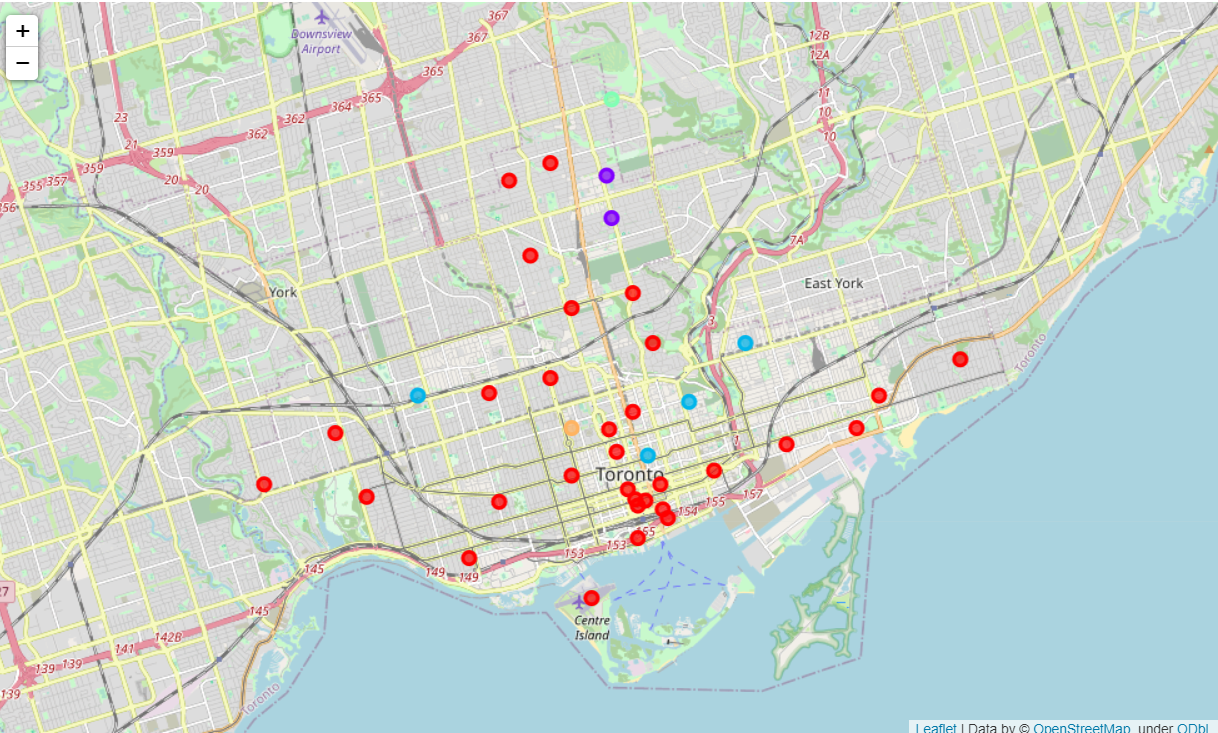

In [50]:
from IPython.display import Image
Image(filename='map.png',width='1080',height='720')

# 5. EXAMINE CLUSTERS
<a id='item5'></a>

## CLUSTER 0

In [51]:
df_toronto.loc[df_toronto['Cluster Labels'] == 0, df_toronto.columns[[1] + list(range(1, df_toronto.shape[1]))]]

,Postal Code,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
3,M5C,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,M4E,East Toronto,The Beaches,43.676357,-79.293031
5,M5E,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
6,M5G,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
7,M6G,M6G,Downtown Toronto,Christie,43.669542,-79.422564
8,M5H,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
10,M5J,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752
11,M6J,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750


## CLUSTER 1

In [52]:
df_toronto.loc[df_toronto['Cluster Labels'] == 1, df_toronto.columns[[1] + list(range(1, df_toronto.shape[1]))]]

,Postal Code,Postal Code,Borough,Neighbourhood,Latitude,Longitude
20,M4P,M4P,Central Toronto,Davisville North,43.712751,-79.390197
26,M4S,M4S,Central Toronto,Davisville,43.704324,-79.388790


## CLUSTER 2

In [53]:
df_toronto.loc[df_toronto['Cluster Labels'] == 2, df_toronto.columns[[1] + list(range(1, df_toronto.shape[1]))]]

,Postal Code,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M5B,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
9,M6H,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259
12,M4K,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
35,M4X,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675


## CLUSTER 3

In [54]:
df_toronto.loc[df_toronto['Cluster Labels'] == 3, df_toronto.columns[[1] + list(range(1, df_toronto.shape[1]))]]

,Postal Code,Postal Code,Borough,Neighbourhood,Latitude,Longitude
18,M4N,M4N,Central Toronto,Lawrence Park,43.72802,-79.38879


## CLUSTER 4

In [55]:
df_toronto.loc[df_toronto['Cluster Labels'] == 4, df_toronto.columns[[1] + list(range(1, df_toronto.shape[1]))]]

,Postal Code,Postal Code,Borough,Neighbourhood,Latitude,Longitude
27,M5S,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049
